In [139]:
import torch
import torchvision
import torch.nn as nn 
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import numpy as np
import math
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from matplotlib import pyplot as plt

In [140]:
def x_normalize(df):
    return (df-df.mean())/(df.var())

def y_normalize(df):
    return (df-df.min())/(df.max() - df.min())

xy = shuffle(shuffle(np.loadtxt('./data_lab3v05.csv', delimiter=',', dtype=np.float32,)))
train_data_size = len(xy) // 10 * 6
val_data_size   = len(xy) // 10 * 3
test_data_size  = len(xy) - train_data_size - val_data_size

X = x_normalize(xy[:, :2])
Y = xy[:, [2]] - 1

X_train = X[:train_data_size]
Y_train = Y[:train_data_size]
X_val   = X[train_data_size:test_data_size + train_data_size]
Y_val   = Y[train_data_size:test_data_size + train_data_size]
X_test  = X[val_data_size + train_data_size:]
Y_test  = Y[val_data_size + train_data_size:]

Y_unique, Y_counts = np.unique(Y, return_counts=True)
print(f'Полная выборка: {len(xy)}, где', dict(zip(Y_unique, Y_counts)))

Y_train_unique, Y_train_counts = np.unique(Y_train, return_counts=True)
print(f'Обучающая выборка: {train_data_size}, где', dict(zip(Y_train_unique, Y_train_counts)))
Y_val_unique, Y_val_counts = np.unique(Y_val, return_counts=True)
print(f'Валидационная выборка: {val_data_size}, где', dict(zip(Y_val_unique, Y_val_counts)))
Y_test_unique, Y_test_counts = np.unique(Y_test, return_counts=True)
print(f'Тренировочная выборка: {test_data_size}, где', dict(zip(Y_test_unique, Y_test_counts)))
Y_train.shape

Полная выборка: 750, где {0.0: 350, 1.0: 250, 2.0: 150}
Обучающая выборка: 450, где {0.0: 212, 1.0: 156, 2.0: 82}
Валидационная выборка: 225, где {0.0: 36, 1.0: 26, 2.0: 13}
Тренировочная выборка: 75, где {0.0: 40, 1.0: 19, 2.0: 16}


(450, 1)

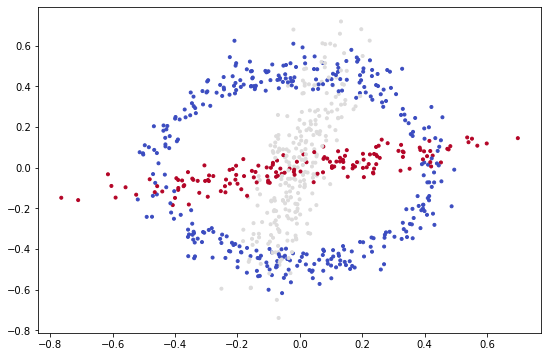

In [141]:
plt.figure(figsize=(9,6))
xlabel = "x"
ylabel = "y"
plt.scatter(X[:, 0], X[:, 1], c=Y, marker='.',  cmap=plt.cm.coolwarm)

In [142]:
BATCH_SIZE = 20
HIDDEN_SIZE_1 = 15
HIDDEN_SIZE_2 = 15
INPUT_SIZE = 2
NUM_CLASSES = 3
LR = 0.1
NUM_EPOCHS = 300

In [188]:
class TrainData(Dataset):
    def __init__(self):
        self.n_samples = X_train.shape[0]        
        self.x_data = torch.from_numpy(X_train)
        self.y_data = torch.from_numpy(Y_train)

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index][0].type(torch.LongTensor)

    def __len__(self):
        return self.n_samples
    
class ValidationData(Dataset):
    def __init__(self):
        self.n_samples = X_val.shape[0]        
        self.x_data = torch.from_numpy(X_val)
        self.y_data = torch.from_numpy(Y_val)
        
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index][0].type(torch.LongTensor)
        
    def __len__ (self):
        return self.n_samples
    
class TestData(Dataset):
    def __init__(self):
        self.n_samples = X_test.shape[0]        
        self.x_data = torch.from_numpy(X_test)
        self.y_data = torch.from_numpy(Y_test)
        
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index][0].type(torch.LongTensor)
        
    def __len__ (self):
        return self.n_samples

In [189]:
train_loader = DataLoader(dataset=TrainData(), batch_size=BATCH_SIZE)
val_loader = DataLoader(dataset=ValidationData(), batch_size=BATCH_SIZE)
test_loader = DataLoader(dataset=TestData(), batch_size=BATCH_SIZE)

In [190]:
total_samples = len(train_loader)
n_iterations = math.ceil(total_samples/BATCH_SIZE)

In [191]:
def save_the_best_model(model):
    torch.save(model.state_dict(), 'models/the_best_model.pth')

In [147]:
def load_model():
    state = torch.load('models/the_best_model.pth')
    new_net = NeuralNet(INPUT_SIZE, HIDDEN_SIZE_1, HIDDEN_SIZE_2, NUM_CLASSES)
    new_net.load_state_dict(state)
    
    return new_net

In [148]:
def plot_decision_boundary(model, X, y):

    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    x_in = np.c_[xx.ravel(), yy.ravel()] 
    y_pred = model.forward(torch.from_numpy(x_in.astype(np.float32)))

    if len(y_pred[0]) > 1:
        print("Multiclass classification:")
        y_pred = np.argmax(y_pred.detach().numpy(), axis=1).reshape(xx.shape)
    else:
        print("Binary classifcation:")
        y_pred = np.round(y_pred.detach().numpy()).reshape(xx.shape)
        
    plt.figure(figsize=(9,6))
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.coolwarm, alpha=0.5)
    plt.scatter(X[:, 0], X[:, 1], c=y, marker='x', s=40, cmap=plt.cm.coolwarm)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())  
    
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, num_classes):
        super(NeuralNet, self).__init__()
        self.linear_1 = nn.Linear(input_size, hidden_size_1)
        torch.nn.init.normal_(self.linear_1.weight)
        self.sigmoid_1 = nn.Sigmoid()
        self.linear_2 = nn.Linear(hidden_size_1, hidden_size_2)  
        torch.nn.init.normal_(self.linear_2.weight)
        self.sigmoid_2 = nn.Sigmoid()
        self.linear_3 = nn.Linear(hidden_size_1, num_classes)
        torch.nn.init.normal_(self.linear_3.weight)
        
        
    def forward(self, x):
        out = self.linear_1(x)
        out = self.sigmoid_1(out)
        out = self.linear_2(out)
        out = self.sigmoid_2(out)
        out = self.linear_3(out)
        y_pred = torch.sigmoid(out)
        return y_pred

In [149]:
def get_loader_loss(loader):
    curr_loss = 0
    for _, data in enumerate(loader, 0):
        inputs, labels = data
        outputs = net(inputs)
        curr_loss += criterion(outputs, labels).item()
    return curr_loss / len(loader.dataset)

In [150]:
def get_loader_epsilon(loader):
    epsilon = 0
    for _, data in enumerate(loader, 0):
        inputs, labels = data 
        for label in labels:
            epsilon += int(torch.argmax(net(inputs)).item() != label.item())

    return epsilon

Multiclass classification:


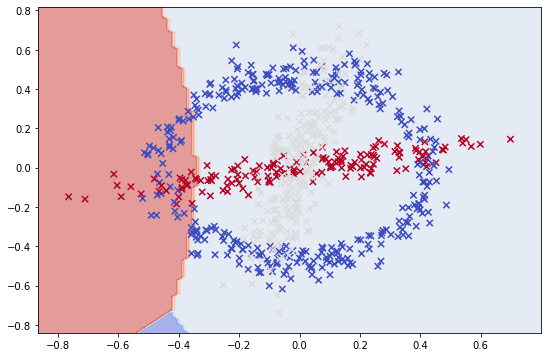

In [173]:
net = NeuralNet(INPUT_SIZE, HIDDEN_SIZE_1, HIDDEN_SIZE_2, NUM_CLASSES)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=LR, momentum=0.1) 
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.9)
plot_decision_boundary(net, X, Y)

In [185]:
def train(patience, epochs):
    print("Training begins...\n")
    
    the_last_loss = 100000
    losses_train = []
    losses_val = []
    losses_test = []
    epsilon_train = []
    epsilon_val = []
    epsilon_test = []
    trigger_times = 0
    
    for epoch in range(epochs):  # loop over the dataset multiple times
        
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        losses_train.append(get_loader_loss(train_loader))
        losses_val.append(get_loader_loss(val_loader))
        losses_test.append(get_loader_loss(test_loader))
        
        epsilon_train.append(get_loader_epsilon(train_loader))
        epsilon_val.append(get_loader_epsilon(val_loader))
        epsilon_test.append(get_loader_epsilon(test_loader))
        
        if losses_val[-1] > the_last_loss:
            trigger_times += 1
            if trigger_times >= patience:
                
                print("Early stoping!")
                net.load_state_dict(torch.load(f'models/the_best_model.pth'))
                net.eval()
                print(f'Epoch: {epoch+1}/{epochs}, Step {i+1}/{n_iterations}\n| Train loss {losses_train[-1]:.3f} | Val loss {losses_val[-1]:.3f}| Test loss {losses_test[-1]:.3f} |')
                return epoch+1, losses_train, losses_val, losses_test, epsilon_train, epsilon_val, epsilon_test                   
        else:
            trigger_times = 0
            save_the_best_model(net)
        the_last_loss = losses_val[-1]
        
        if epoch % 100 ==0:
            print(f'Epoch: {epoch+1}/{epochs}, Step {i+1}/{n_iterations}\n| Train loss {losses_train[-1]:.3f} | Val loss {losses_val[-1]:.3f}| Test loss {losses_test[-1]:.3f} |')
        
    print("Training finished")
    return epoch+1, losses_train, losses_val, losses_test, epsilon_train, epsilon_val, epsilon_test

In [186]:
def plot_train(epoch, losses_train, losses_val, losses_test, epsilon_train, epsilon_val, epsilon_test):
    plt.title('Функция потерь', fontsize=20)        
    plt.plot(np.linspace(1, epoch, epoch).astype(int), losses_train)      
    plt.plot(np.linspace(1, epoch, epoch).astype(int), losses_val)
    plt.plot(np.linspace(1, epoch, epoch).astype(int), losses_test)
    plt.xlabel('$t$', color='gray')
    plt.ylabel('$E(t)$',color='gray')
    plt.legend(['Обучающая выборка','Валидационная выборка','Тестовая выборка'], loc=1)
    plt.show()
    
    plt.title('Ошибка классификации', fontsize=20)
    plt.plot(np.linspace(1, epoch, epoch).astype(int), epsilon_train)
    plt.plot(np.linspace(1, epoch, epoch).astype(int), epsilon_val)
    plt.plot(np.linspace(1, epoch, epoch).astype(int), epsilon_test)
    plt.xlabel('$t$', color='gray')
    plt.ylabel('$E(t)$',color='gray')
    plt.legend(['Обучающая выборка','Валидационная выборка','Тестовая выборка'], loc=1)
    plt.show()

Training begins...

Epoch: 1/1000, Step 23/2
| Train loss 0.049 | Val loss 0.050| Test loss 0.052 |
Epoch: 101/1000, Step 23/2
| Train loss 0.049 | Val loss 0.049| Test loss 0.052 |
Epoch: 201/1000, Step 23/2
| Train loss 0.049 | Val loss 0.049| Test loss 0.052 |
Epoch: 301/1000, Step 23/2
| Train loss 0.049 | Val loss 0.049| Test loss 0.052 |
Epoch: 401/1000, Step 23/2
| Train loss 0.049 | Val loss 0.049| Test loss 0.052 |
Epoch: 501/1000, Step 23/2
| Train loss 0.049 | Val loss 0.049| Test loss 0.052 |
Epoch: 601/1000, Step 23/2
| Train loss 0.049 | Val loss 0.049| Test loss 0.052 |
Epoch: 701/1000, Step 23/2
| Train loss 0.049 | Val loss 0.049| Test loss 0.052 |
Epoch: 801/1000, Step 23/2
| Train loss 0.048 | Val loss 0.048| Test loss 0.052 |
Epoch: 901/1000, Step 23/2
| Train loss 0.048 | Val loss 0.048| Test loss 0.051 |
Training finished


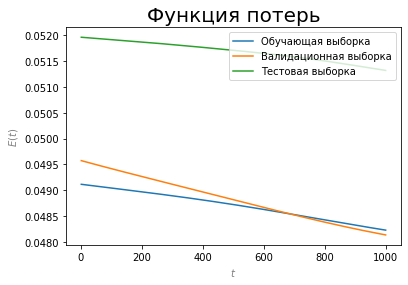

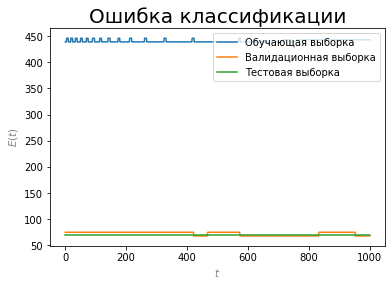

losses_train 0.04822714924812317
losses_val 0.04813432693481445
losses_test 0.0513224736849467
epsilon_train 443
epsilon_val 68
epsilon_test 69


In [187]:
epoch, losses_train, losses_val, losses_test, epsilon_train, epsilon_val, epsilon_test = train(20, 1000)
plot_train(epoch, losses_train, losses_val, losses_test, epsilon_train, epsilon_val, epsilon_test)

print('losses_train ' + str(losses_train[-1]))
print('losses_val ' + str(losses_val[-1]))
print('losses_test ' + str(losses_test[-1]))
print('epsilon_train ' + str(epsilon_train[-1]))
print('epsilon_val ' + str(epsilon_val[-1]))
print('epsilon_test ' + str(epsilon_test[-1]))

Multiclass classification:


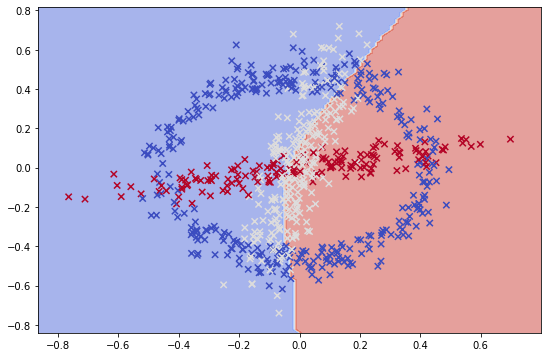

In [192]:
plot_decision_boundary(net, X, Y)

In [193]:
net.state_dict()

OrderedDict([('linear_1.weight',
              tensor([[-0.3035,  1.7738],
                      [ 3.8655,  0.2714],
                      [-1.9333,  1.7937],
                      [ 3.5546, -1.9111],
                      [-3.6389,  0.4177],
                      [-3.5393, -4.8012],
                      [-2.1878, -0.7188],
                      [-1.5421,  2.2758],
                      [-2.2307, -1.0815],
                      [-1.2618, -0.1820],
                      [-1.0889,  0.2615],
                      [-2.6989,  0.3506],
                      [ 0.1549, -1.7796],
                      [-1.6356, -0.5387],
                      [ 4.1026, -5.1559]])),
             ('linear_1.bias',
              tensor([-0.3971,  0.4654, -0.3617,  0.7714, -0.4902, -1.3487, -0.2061,  0.1082,
                      -0.2134, -0.5420, -0.2978, -0.5162, -0.1608, -0.5516,  1.0766])),
             ('linear_2.weight',
              tensor([[ 1.1200, -0.2946,  0.4170, -1.1534,  0.9180,  3.3415,  1.1417,  1

In [194]:
torch.save(net.state_dict(), 'models/the_best_model.pth') 

In [195]:
net = load_model()

In [197]:
print(sum(losses_train) / len(losses_train))
print(sum(losses_val) / len(losses_val))
print(sum(losses_test) / len(losses_test))

0.048701288043922875
0.04882469558397929
0.051690286118984186


In [198]:
print(sum(epsilon_train) / len(epsilon_train))
print(sum(epsilon_val) / len(epsilon_val))
print(sum(epsilon_test) / len(epsilon_test))

440.686
72.529
69.0


In [201]:
len(Y_test)

75

In [202]:
def predict(loader):
    list = []
    for _, data in enumerate(loader, 0):
        inputs, labels = data
        output = torch.argmax(net(inputs)).item()
        list.append(output)
        
    return np.array(list)

predict(train_loader)
len(predict(train_loader))

23

In [203]:
from sklearn.metrics import confusion_matrix

In [204]:
confusion_matrix(Y_train, predict(train_loader)) 

ValueError: Found input variables with inconsistent numbers of samples: [450, 23]

In [184]:
confusion_matrix(Y_test, predict(test_loader))

ValueError: Found input variables with inconsistent numbers of samples: [75, 4]